# Other Samplers

Trey V. Wenger (c) October 2024

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0b0+0.g0b1514f.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

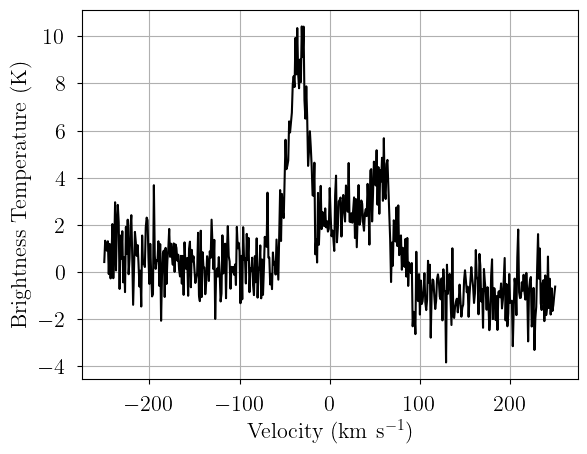

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's try the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 4,
    cores = 4,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Adding log-likelihood to trace


Output()

In [7]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [2 0 1]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

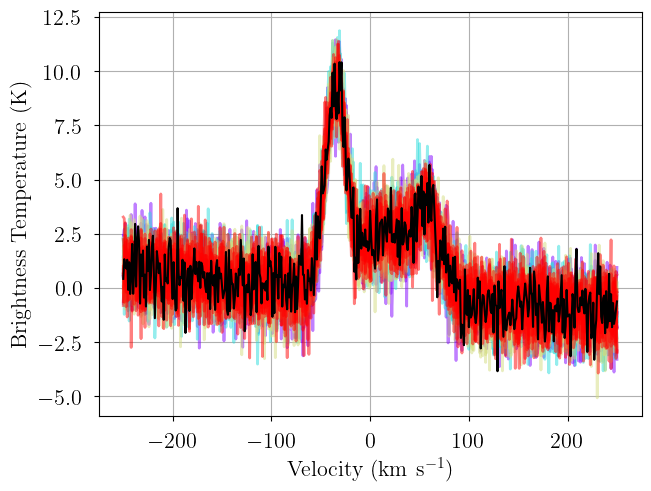

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

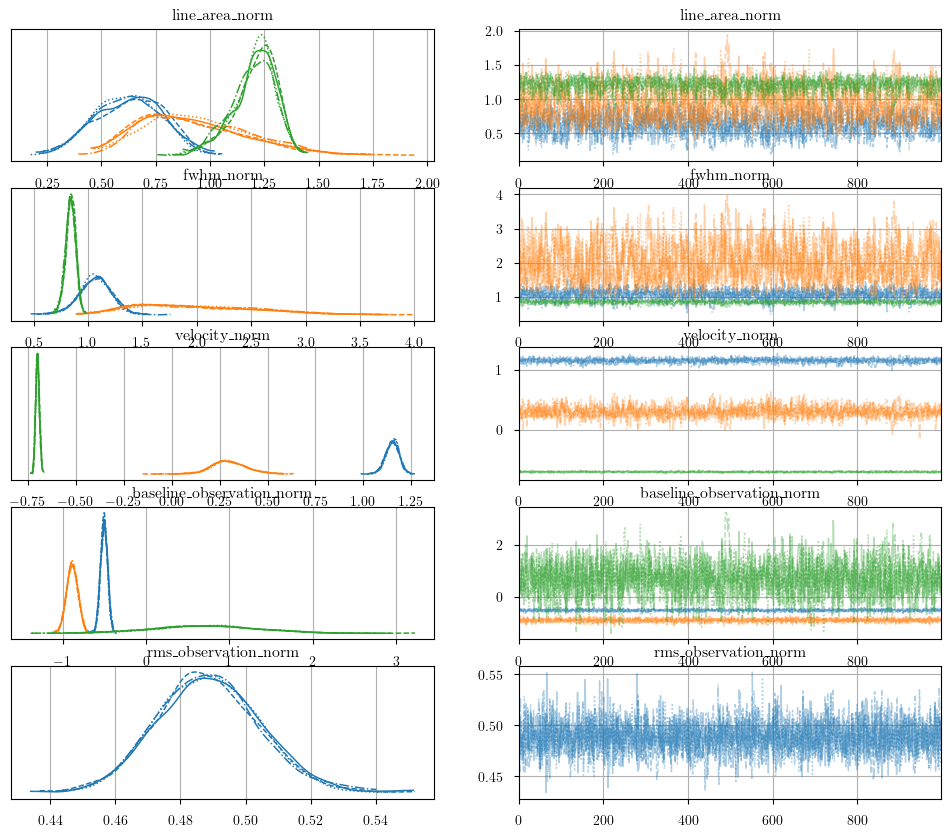

In [9]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    3.636   0.568    2.601    4.583      0.017   
amplitude[1]                    2.942   0.240    2.494    3.404      0.004   
amplitude[2]                    8.950   0.435    8.073    9.707      0.012   
baseline_observation_norm[0]   -0.505   0.043   -0.583   -0.423      0.001   
baseline_observation_norm[1]   -0.886   0.067   -1.008   -0.759      0.001   
baseline_observation_norm[2]    0.722   0.641   -0.550    1.849      0.014   
fwhm[0]                        31.975   4.473   23.277   40.121      0.124   
fwhm[1]                        59.711  16.509   32.368   88.905      0.568   
fwhm[2]                        25.213   1.406   22.529   27.877      0.040   
fwhm_norm[0]                    1.066   0.149    0.776    1.337      0.004   
fwhm_norm[1]                    1.990   0.550    1.079    2.963      0.019   
fwhm_norm[2]                    0.840   0.047    0.751    0.929      0.001   
line_area[0]                  124.902  30.296   71.054  180.644      0.958   
line_area[1]                  185.653  48.922  107.563  279.713      1.701   
line_area[2]                  240.394  19.957  200.605  274.750      0.653   
line_area_norm[0]               0.625   0.151    0.355    0.903      0.005   
line_area_norm[1]               0.928   0.245    0.538    1.399      0.009   
line_area_norm[2]               1.202   0.100    1.003    1.374      0.003   
rms_observation                 0.977   0.031    0.920    1.036      0.001   
rms_observation_norm            0.489   0.016    0.460    0.518      0.000   
velocity[0]                    57.516   1.710   54.270   60.698      0.039   
velocity[1]                    15.037   4.639    7.017   24.653      0.126   
velocity[2]                   -34.927   0.479  -35.787  -34.014      0.010   
velocity_norm[0]                1.150   0.034    1.085    1.214      0.001   
velocity_norm[1]                0.301   0.093    0.140    0.493      0.003   
velocity_norm[2]               -0.699   0.010   -0.716   -0.680      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.012    1188.0    1993.0    1.0  
amplitude[1]                    0.003    2975.0    3347.0    1.0  
amplitude[2]                    0.009    1365.0    1623.0    1.0  
baseline_observation_norm[0]    0.001    1967.0    1725.0    1.0  
baseline_observation_norm[1]    0.001    4068.0    2990.0    1.0  
baseline_observation_norm[2]    0.012    2048.0    1845.0    1.0  
fwhm[0]                         0.088    1376.0    1216.0    1.0  
fwhm[1]                         0.406     889.0    1373.0    1.0  
fwhm[2]                         0.028    1324.0    1494.0    1.0  
fwhm_norm[0]                    0.003    1376.0    1216.0    1.0  
fwhm_norm[1]                    0.014     889.0    1373.0    1.0  
fwhm_norm[2]                    0.001    1324.0    1494.0    1.0  
line_area[0]                    0.678    1005.0    1002.0    1.0  
line_area[1]                    1.222     875.0    1242.0    1.0  
line_area[2]                    0.462    1007.0    1107.0    1.0  
line_area_norm[0]               0.003    1005.0    1002.0    1.0  
line_area_norm[1]               0.006     875.0    1242.0    1.0  
line_area_norm[2]               0.002    1007.0    1107.0    1.0  
rms_observation                 0.000    3715.0    2629.0    1.0  
rms_observation_norm            0.000    3715.0    2629.0    1.0  
velocity[0]                     0.028    1933.0    2397.0    1.0  
velocity[1]                     0.089    1413.0    1570.0    1.0  
velocity[2]                     0.007    2141.0    2361.0    1.0  
velocity_norm[0]                0.001    1933.0    2397.0    1.0  
velocity_norm[1]                0.002    1413.0    1570.0    1.0  
velocity_norm[2]                0.000    2141.0    2361.0    1.0

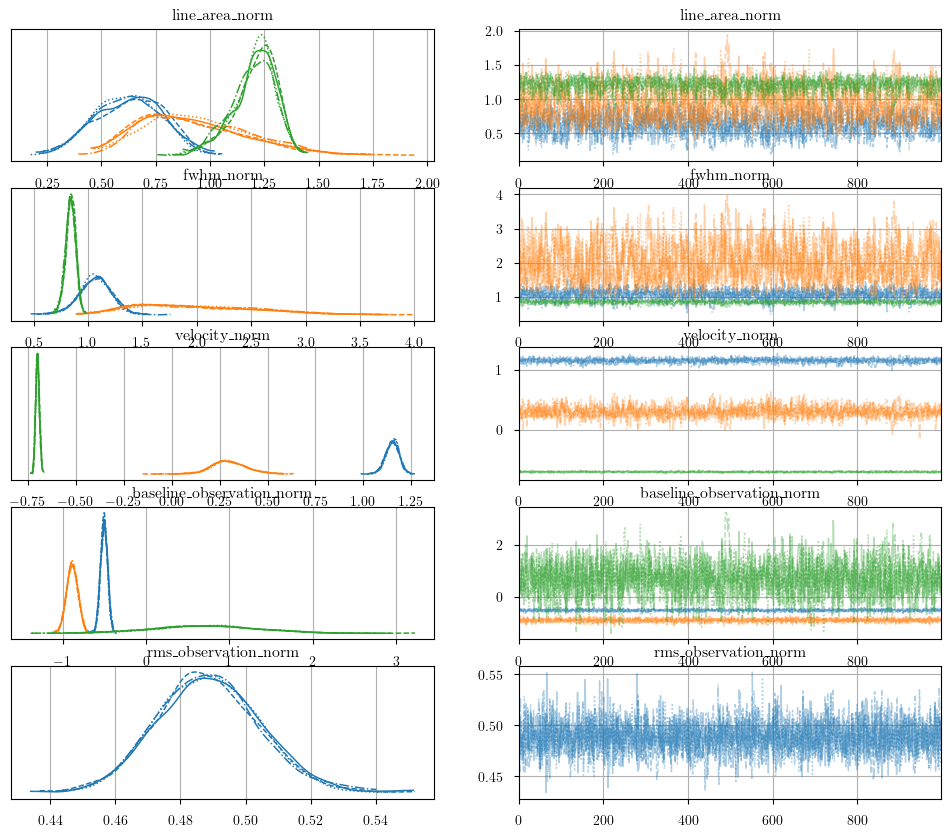

In [11]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference).

In [12]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

Adding log-likelihood to trace


Output()

After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [13]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 0 1]
Chain 1 order: [0 2 1]
Chain 2 order: [0 2 1]
Chain 3 order: [1 0 2]
Chain 4 order: [0 1 2]
Chain 5 order: [1 2 0]
Adopting (first) most common order: [0 2 1]


Sampling: [observation]


Output()

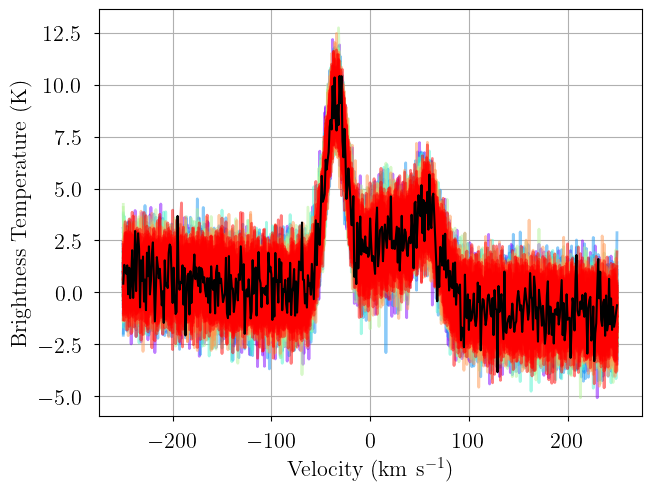

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

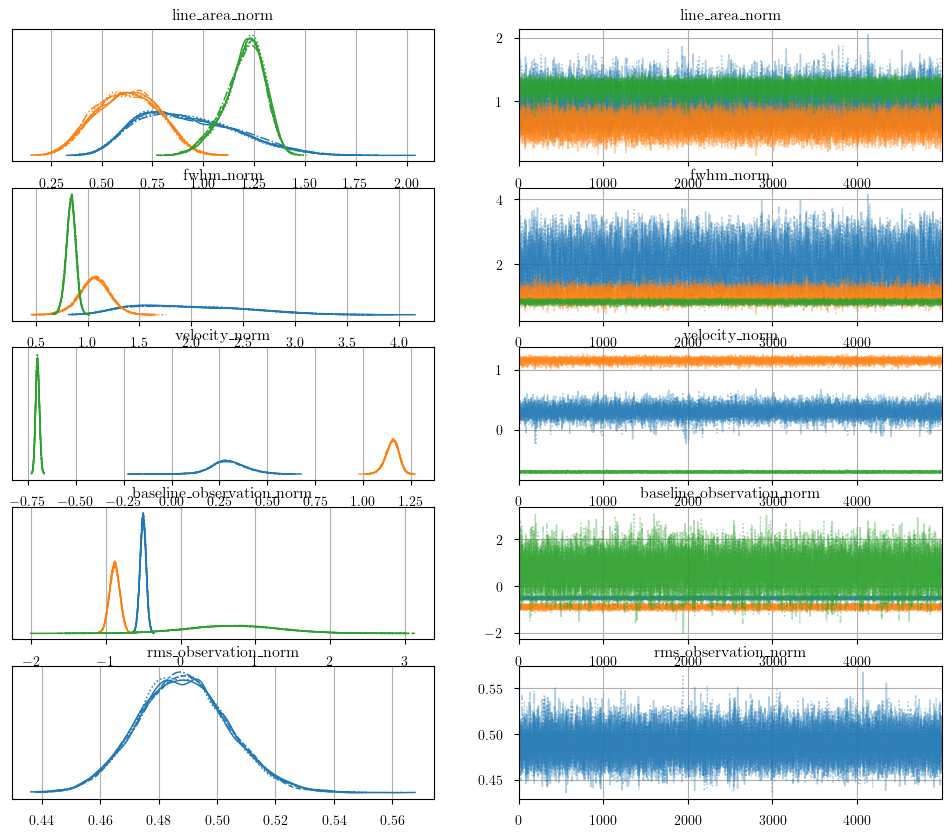

In [15]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [16]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    2.935   0.239    2.476    3.378      0.002   
amplitude[1]                    3.639   0.559    2.616    4.582      0.007   
amplitude[2]                    8.951   0.425    8.107    9.684      0.005   
baseline_observation_norm[0]   -0.504   0.041   -0.582   -0.428      0.000   
baseline_observation_norm[1]   -0.885   0.068   -1.012   -0.758      0.000   
baseline_observation_norm[2]    0.699   0.622   -0.432    1.908      0.004   
fwhm[0]                        59.501  16.204   32.261   88.444      0.237   
fwhm[1]                        32.033   4.448   23.528   40.545      0.047   
fwhm[2]                        25.222   1.385   22.585   27.824      0.016   
fwhm_norm[0]                    1.983   0.540    1.075    2.948      0.008   
fwhm_norm[1]                    1.068   0.148    0.784    1.351      0.002   
fwhm_norm[2]                    0.841   0.046    0.753    0.927      0.001   
fwhm_norm_log__[0]              0.273   0.432   -0.284    1.021      0.156   
fwhm_norm_log__[1]              0.217   0.371   -0.281    0.971      0.130   
fwhm_norm_log__[2]              0.037   0.324   -0.320    0.811      0.119   
line_area[0]                  184.596  47.995  102.348  271.870      0.688   
line_area[1]                  125.224  30.261   69.514  179.122      0.401   
line_area[2]                  240.494  19.590  201.495  274.442      0.265   
line_area_norm[0]               0.923   0.240    0.512    1.359      0.003   
line_area_norm[1]               0.626   0.151    0.348    0.896      0.002   
line_area_norm[2]               1.202   0.098    1.007    1.372      0.001   
line_area_norm_log__[0]        -0.081   0.316   -0.673    0.351      0.094   
line_area_norm_log__[1]        -0.253   0.352   -0.855    0.329      0.107   
line_area_norm_log__[2]        -0.098   0.365   -0.793    0.333      0.127   
rms_observation                 0.977   0.031    0.918    1.034      0.000   
rms_observation_norm            0.489   0.016    0.459    0.517      0.000   
rms_observation_norm_log__     -0.717   0.032   -0.779   -0.659      0.000   
velocity[0]                    15.013   4.627    6.909   24.330      0.047   
velocity[1]                    57.498   1.724   54.152   60.627      0.016   
velocity[2]                   -34.932   0.488  -35.850  -34.015      0.004   
velocity_norm[0]                0.300   0.093    0.138    0.487      0.001   
velocity_norm[1]                1.150   0.034    1.083    1.213      0.000   
velocity_norm[2]               -0.699   0.010   -0.717   -0.680      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.001   21573.0   25865.0   1.00  
amplitude[1]                    0.005    6269.0   15831.0   1.00  
amplitude[2]                    0.003    8088.0   10542.0   1.00  
baseline_observation_norm[0]    0.000   18089.0   17392.0   1.00  
baseline_observation_norm[1]    0.000   38316.0   22474.0   1.00  
baseline_observation_norm[2]    0.003   20119.0   19666.0   1.00  
fwhm[0]                         0.168    4825.0    9622.0   1.00  
fwhm[1]                         0.033    8988.0   11233.0   1.00  
fwhm[2]                         0.011    7854.0   10617.0   1.00  
fwhm_norm[0]                    0.006    4825.0    9622.0   1.00  
fwhm_norm[1]                    0.001    8988.0   11233.0   1.00  
fwhm_norm[2]                    0.000    7854.0   10617.0   1.00  
fwhm_norm_log__[0]              0.115       9.0      95.0   1.82  
fwhm_norm_log__[1]              0.096       9.0      68.0   1.84  
fwhm_norm_log__[2]              0.088       9.0      24.0   1.72  
line_area[0]                    0.487    4984.0   11060.0   1.00  
line_area[1]                    0.284    5770.0   10491.0   1.00  
line_area[2]                    0.188    5757.0    7643.0   1.00  
line_area_norm[0]               0.002    4984.0   11060.0   1.00  
line_area_norm[1]               0.001   

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [17]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [18]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Adding log-likelihood to trace


Output()

In [19]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 0 2]
Chain 4 order: [2 1 0]
Chain 5 order: [2 0 1]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

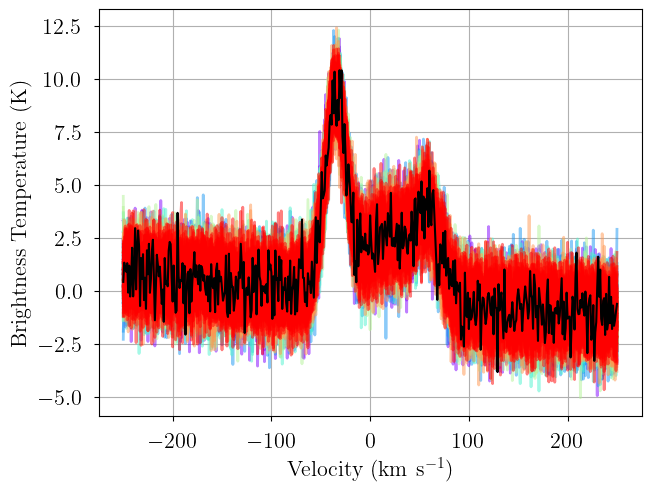

In [20]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

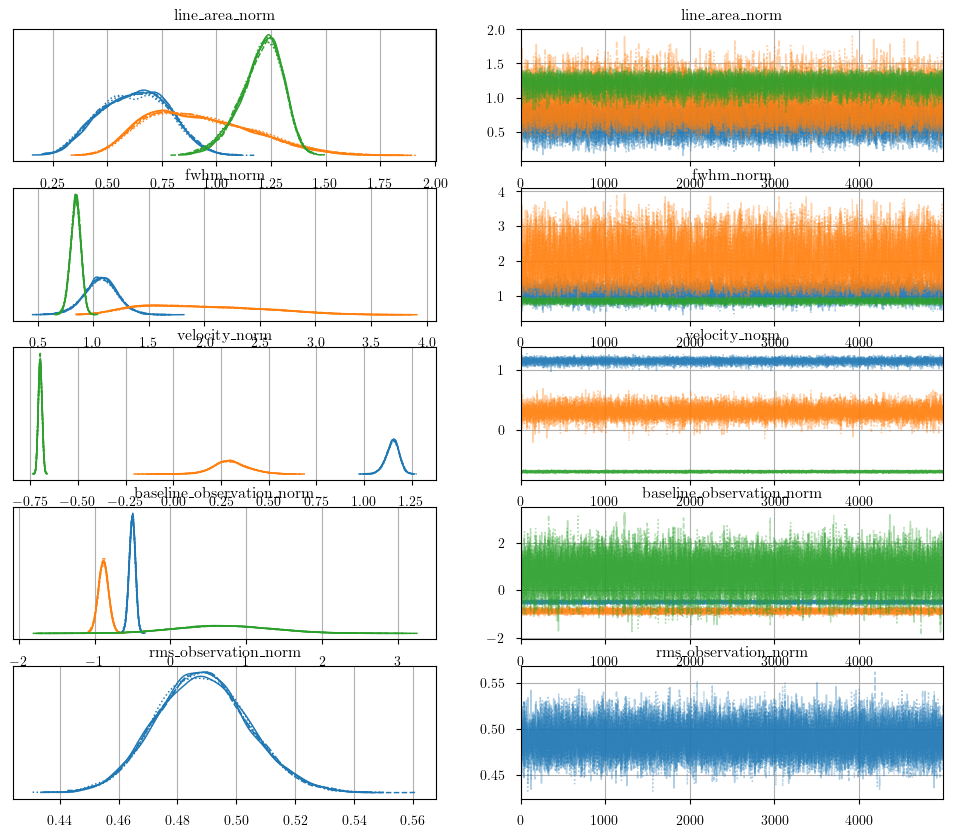

In [21]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [22]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    3.638   0.568    2.618    4.621      0.007   
amplitude[1]                    2.934   0.241    2.480    3.387      0.002   
amplitude[2]                    8.951   0.428    8.131    9.722      0.005   
baseline_observation_norm[0]   -0.505   0.042   -0.583   -0.427      0.000   
baseline_observation_norm[1]   -0.884   0.068   -1.012   -0.756      0.000   
baseline_observation_norm[2]    0.699   0.631   -0.491    1.880      0.005   
fwhm[0]                        31.996   4.536   23.455   40.834      0.049   
fwhm[1]                        59.505  16.293   32.544   88.908      0.228   
fwhm[2]                        25.236   1.390   22.583   27.812      0.015   
fwhm_norm[0]                    1.067   0.151    0.782    1.361      0.002   
fwhm_norm[1]                    1.983   0.543    1.085    2.964      0.008   
fwhm_norm[2]                    0.841   0.046    0.753    0.927      0.001   
line_area[0]                  125.091  30.795   68.185  179.530      0.402   
line_area[1]                  184.650  48.624  105.213  276.873      0.682   
line_area[2]                  240.639  19.621  201.214  273.921      0.251   
line_area_norm[0]               0.625   0.154    0.341    0.898      0.002   
line_area_norm[1]               0.923   0.243    0.526    1.384      0.003   
line_area_norm[2]               1.203   0.098    1.006    1.370      0.001   
rms_observation                 0.977   0.031    0.919    1.035      0.000   
rms_observation_norm            0.489   0.015    0.459    0.517      0.000   
velocity[0]                    57.471   1.729   54.215   60.738      0.016   
velocity[1]                    15.077   4.680    6.699   24.447      0.046   
velocity[2]                   -34.933   0.485  -35.867  -34.048      0.004   
velocity_norm[0]                1.149   0.035    1.084    1.215      0.000   
velocity_norm[1]                0.302   0.094    0.134    0.489      0.001   
velocity_norm[2]               -0.699   0.010   -0.717   -0.681      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.005    6913.0   17105.0    1.0  
amplitude[1]                    0.001   22407.0   22738.0    1.0  
amplitude[2]                    0.003    9373.0   11682.0    1.0  
baseline_observation_norm[0]    0.000   16693.0   17320.0    1.0  
baseline_observation_norm[1]    0.000   26843.0   19515.0    1.0  
baseline_observation_norm[2]    0.004   17807.0   18484.0    1.0  
fwhm[0]                         0.034    8789.0   11309.0    1.0  
fwhm[1]                         0.161    5219.0   12527.0    1.0  
fwhm[2]                         0.011    8532.0   11528.0    1.0  
fwhm_norm[0]                    0.001    8789.0   11309.0    1.0  
fwhm_norm[1]                    0.005    5219.0   12527.0    1.0  
fwhm_norm[2]                    0.000    8532.0   11528.0    1.0  
line_area[0]                    0.284    5937.0   11274.0    1.0  
line_area[1]                    0.482    5152.0   12182.0    1.0  
line_area[2]                    0.178    6352.0    9379.0    1.0  
line_area_norm[0]               0.001    5937.0   11274.0    1.0  
line_area_norm[1]               0.002    5152.0   12182.0    1.0  
line_area_norm[2]               0.001    6352.0    9379.0    1.0  
rms_observation                 0.000   26911.0   20477.0    1.0  
rms_observation_norm            0.000   26911.0   20477.0    1.0  
velocity[0]                     0.011   11684.0   14602.0    1.0  
velocity[1]                     0.034   10281.0   13017.0    1.0  
velocity[2]                     0.003   12560.0   19020.0    1.0  
velocity_norm[0]                0.000   11684.0   14602.0    1.0  
velocity_norm[1]                0.001   10281.0   13017.0    1.0  
velocity_norm[2]                0.000   12560.0   19020.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [23]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/sampling/jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


Adding log-likelihood to trace


Output()

In [24]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 0 2]
Chain 4 order: [2 1 0]
Chain 5 order: [2 0 1]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

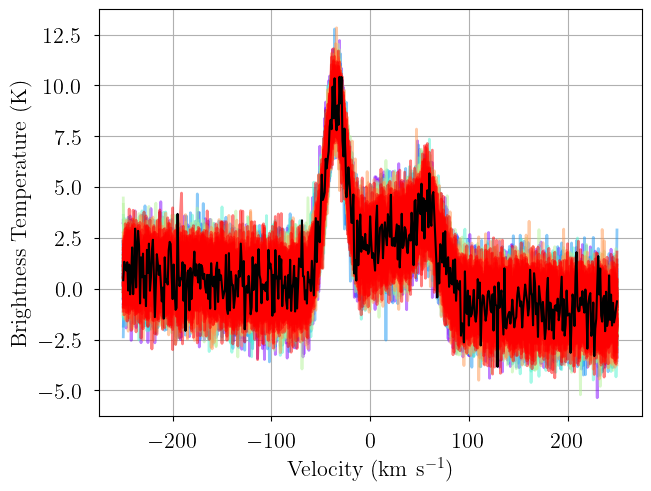

In [25]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

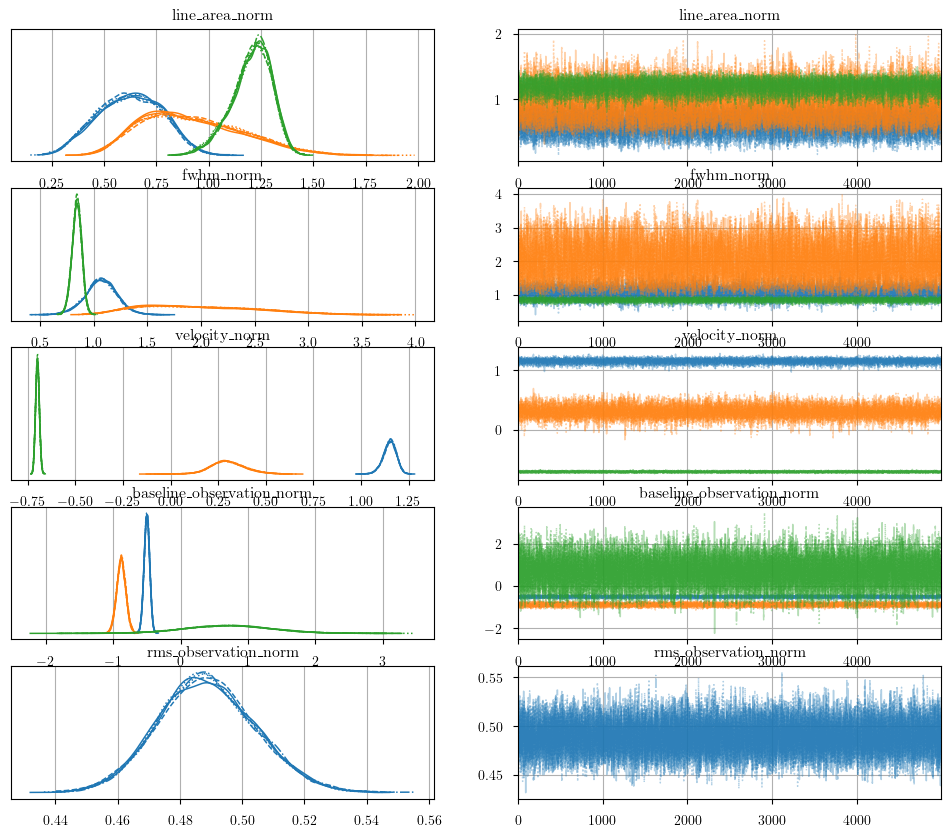

In [26]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [27]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    3.630   0.566    2.605    4.597      0.007   
amplitude[1]                    2.935   0.240    2.486    3.393      0.002   
amplitude[2]                    8.955   0.424    8.140    9.724      0.004   
baseline_observation_norm[0]   -0.505   0.042   -0.578   -0.422      0.000   
baseline_observation_norm[1]   -0.885   0.067   -1.013   -0.759      0.000   
baseline_observation_norm[2]    0.703   0.633   -0.444    1.945      0.005   
fwhm[0]                        31.996   4.481   23.208   40.347      0.049   
fwhm[1]                        59.564  16.161   32.986   88.912      0.225   
fwhm[2]                        25.231   1.362   22.618   27.764      0.015   
fwhm_norm[0]                    1.067   0.149    0.774    1.345      0.002   
fwhm_norm[1]                    1.985   0.539    1.100    2.964      0.007   
fwhm_norm[2]                    0.841   0.045    0.754    0.925      0.000   
line_area[0]                  124.788  30.487   66.331  176.916      0.408   
line_area[1]                  184.863  48.105  103.043  271.980      0.666   
line_area[2]                  240.688  19.203  202.450  273.281      0.241   
line_area_norm[0]               0.624   0.152    0.332    0.885      0.002   
line_area_norm[1]               0.924   0.241    0.515    1.360      0.003   
line_area_norm[2]               1.203   0.096    1.012    1.366      0.001   
rms_observation                 0.977   0.031    0.920    1.036      0.000   
rms_observation_norm            0.489   0.016    0.460    0.518      0.000   
velocity[0]                    57.508   1.726   54.037   60.532      0.016   
velocity[1]                    15.148   4.625    6.966   24.545      0.048   
velocity[2]                   -34.930   0.485  -35.858  -34.032      0.004   
velocity_norm[0]                1.150   0.035    1.081    1.211      0.000   
velocity_norm[1]                0.303   0.093    0.139    0.491      0.001   
velocity_norm[2]               -0.699   0.010   -0.717   -0.681      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.005    6579.0   16952.0    1.0  
amplitude[1]                    0.001   22845.0   23650.0    1.0  
amplitude[2]                    0.003    9853.0   13889.0    1.0  
baseline_observation_norm[0]    0.000   15119.0   16152.0    1.0  
baseline_observation_norm[1]    0.000   26994.0   20251.0    1.0  
baseline_observation_norm[2]    0.004   16205.0   17593.0    1.0  
fwhm[0]                         0.035    8447.0   13554.0    1.0  
fwhm[1]                         0.159    5303.0   10928.0    1.0  
fwhm[2]                         0.010    8858.0   11567.0    1.0  
fwhm_norm[0]                    0.001    8447.0   13554.0    1.0  
fwhm_norm[1]                    0.005    5303.0   10928.0    1.0  
fwhm_norm[2]                    0.000    8858.0   11567.0    1.0  
line_area[0]                    0.288    5665.0   11671.0    1.0  
line_area[1]                    0.471    5296.0   11951.0    1.0  
line_area[2]                    0.170    6556.0    9746.0    1.0  
line_area_norm[0]               0.001    5665.0   11671.0    1.0  
line_area_norm[1]               0.002    5296.0   11951.0    1.0  
line_area_norm[2]               0.001    6556.0    9746.0    1.0  
rms_observation                 0.000   26583.0   19488.0    1.0  
rms_observation_norm            0.000   26583.0   19488.0    1.0  
velocity[0]                     0.012   11431.0   15133.0    1.0  
velocity[1]                     0.035    9396.0   13488.0    1.0  
velocity[2]                     0.003   12413.0   18750.0    1.0  
velocity_norm[0]                0.000   11431.0   15133.0    1.0  
velocity_norm[1]                0.001    9396.0   13488.0    1.0  
velocity_norm[2]                0.000   12413.0   18750.0    1.0

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [28]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Adding log-likelihood to trace


Output()

In [29]:
model.solve()

No solution found!
0 of 8 chains appear converged.


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

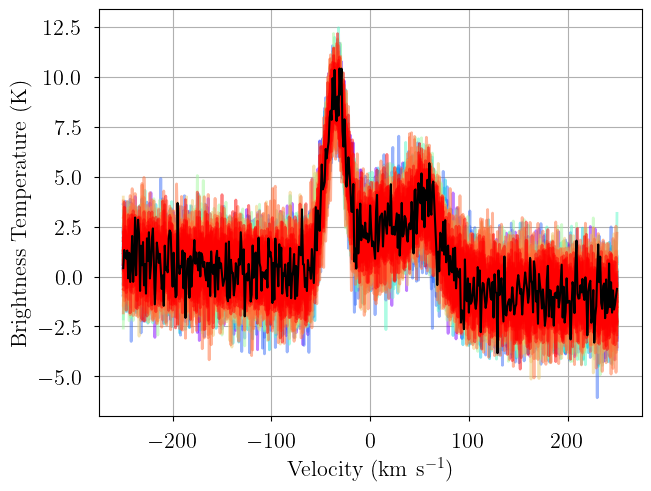

In [30]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

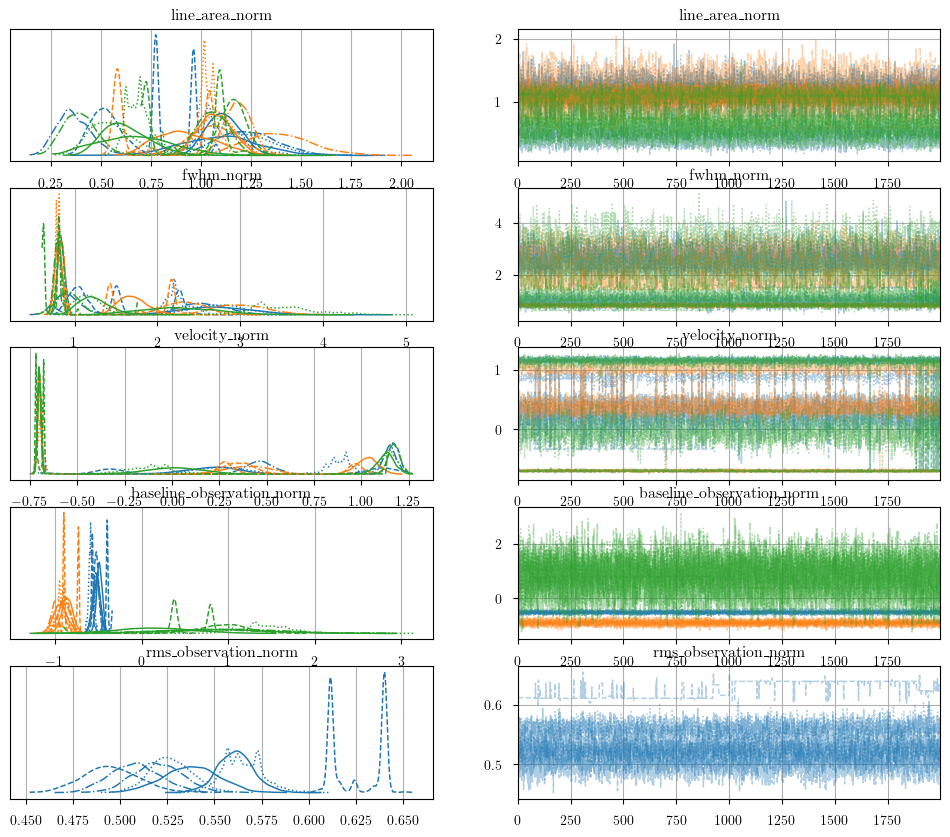

In [31]:
_ = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [32]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


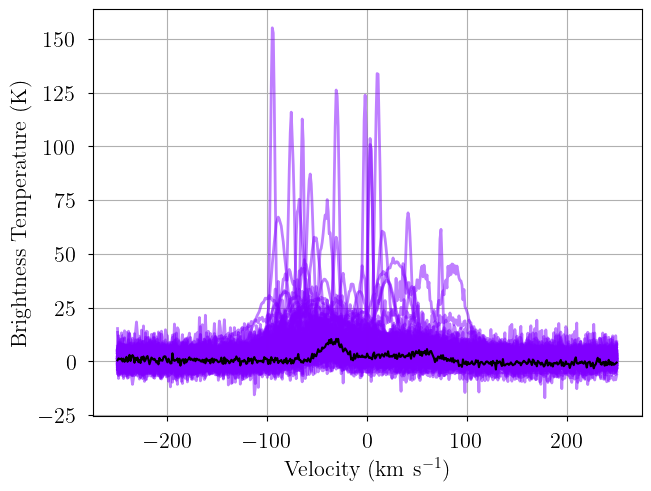

In [33]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [34]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Adding log-likelihood to trace


Output()

In [35]:
model.solve()

GMM converged to unique solution


Sampling: [observation]


Output()

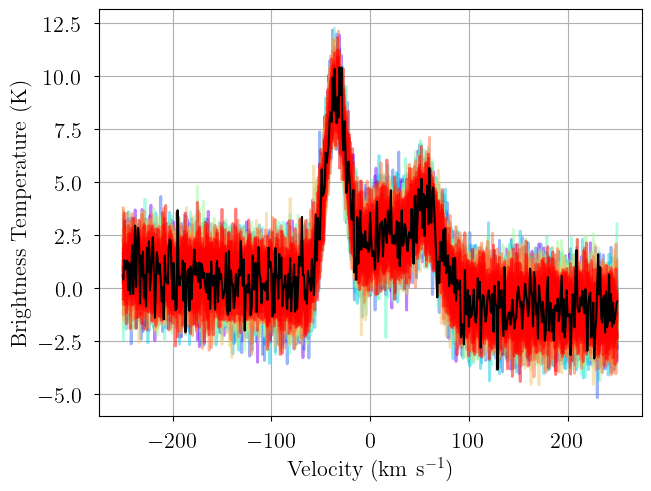

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

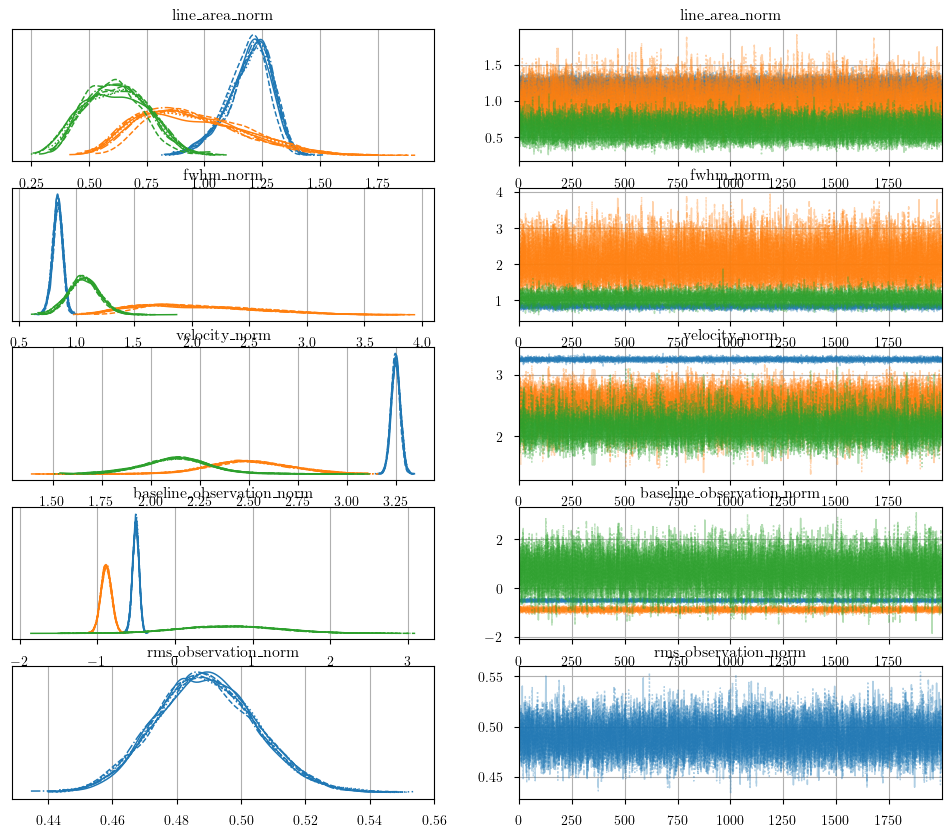

In [37]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [38]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.923   0.432    8.074    9.698      0.004   
amplitude[1]                    2.912   0.233    2.471    3.343      0.002   
amplitude[2]                    3.604   0.521    2.666    4.541      0.004   
baseline_observation_norm[0]   -0.504   0.042   -0.585   -0.427      0.000   
baseline_observation_norm[1]   -0.884   0.067   -1.008   -0.754      0.001   
baseline_observation_norm[2]    0.702   0.636   -0.461    1.925      0.005   
fwhm[0]                        25.108   1.338   22.564   27.601      0.011   
fwhm[1]                        61.174  15.134   37.274   89.641      0.133   
fwhm[2]                        32.006   4.030   24.273   39.381      0.035   
fwhm_norm[0]                    0.837   0.045    0.752    0.920      0.000   
fwhm_norm[1]                    2.039   0.504    1.242    2.988      0.004   
fwhm_norm[2]                    1.067   0.134    0.809    1.313      0.001   
line_area[0]                  238.646  19.166  199.539  270.464      0.163   
line_area[1]                  188.494  44.570  116.937  274.307      0.392   
line_area[2]                  123.458  26.683   74.628  170.707      0.238   
line_area_norm[0]               1.193   0.096    0.998    1.352      0.001   
line_area_norm[1]               0.942   0.223    0.585    1.372      0.002   
line_area_norm[2]               0.617   0.133    0.373    0.854      0.001   
rms_observation                 0.978   0.031    0.918    1.034      0.000   
rms_observation_norm            0.489   0.016    0.459    0.517      0.000   
velocity[0]                   -34.984   0.463  -35.829  -34.103      0.004   
velocity[1]                    14.980   4.393    7.146   23.512      0.037   
velocity[2]                    57.705   1.609   54.644   60.706      0.013   
velocity_norm[0]                3.251   0.023    3.209    3.295      0.000   
velocity_norm[1]                2.498   0.217    2.109    2.918      0.002   
velocity_norm[2]                2.136   0.187    1.773    2.483      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003   14706.0   14004.0   1.00  
amplitude[1]                    0.001   15782.0   15374.0   1.00  
amplitude[2]                    0.003   13615.0   12144.0   1.00  
baseline_observation_norm[0]    0.000   15650.0   14158.0   1.00  
baseline_observation_norm[1]    0.000   15840.0   14384.0   1.00  
baseline_observation_norm[2]    0.004   15913.0   14055.0   1.00  
fwhm[0]                         0.008   13837.0   15146.0   1.00  
fwhm[1]                         0.094   12407.0   10553.0   1.01  
fwhm[2]                         0.025   12702.0   11719.0   1.00  
fwhm_norm[0]                    0.000   13837.0   15146.0   1.00  
fwhm_norm[1]                    0.003   12407.0   10553.0   1.01  
fwhm_norm[2]                    0.001   12702.0   11719.0   1.00  
line_area[0]                    0.116   13730.0   13979.0   1.00  
line_area[1]                    0.277   12477.0   12508.0   1.01  
line_area[2]                    0.169   11224.0    9648.0   1.01  
line_area_norm[0]               0.001   13730.0   13979.0   1.00  
line_area_norm[1]               0.001   12477.0   12508.0   1.01  
line_area_norm[2]               0.001   11224.0    9648.0   1.01  
rms_observation                 0.000   14664.0   15084.0   1.00  
rms_observation_norm            0.000   14664.0   15084.0   1.00  
velocity[0]                     0.003   14754.0   13836.0   1.00  
velocity[1]                     0.027   13828.0   12164.0   1.00  
velocity[2]                     0.009   14962.0   12485.0   1.00  
velocity_norm[0]                0.000   14754.0   13836.0   1.00  
velocity_norm[1]                0.001   13803.0   11711.0   1.00  
velocity_norm[2]                0.001   14066.0   10871.0   1.00